In [ ]:
!pip install pennylane

In [2]:
import pennylane as qml
from pennylane import numpy as np
from pennylane.optimize import NesterovMomentumOptimizer
%matplotlib inline
import matplotlib.pyplot as plt

In [3]:
dev = qml.device("default.qubit", wires=2)

### Utility Functions

In [17]:
def cost(weights, features, labels, direction):
    predictions = [variational_classifier(weights, f, direction) for f in features]
    return square_loss(labels, predictions)

def square_loss(labels, predictions):
    loss = 0
    for l, p in zip(labels, predictions):
        loss = loss + (l - p) ** 2

    loss = loss / len(labels)
    return loss

def accuracy(labels, predictions):
    loss = 0
    for l, p in zip(labels, predictions):
        if abs(l - p) < 1e-5:
            loss = loss + 1
    loss = loss / len(labels)
    return loss

## 1. State Encoding

To translate real-valued feature vectors into states, we first generate some angles from the vectors and then pass those to the state preparation routine.

In [5]:
def generate_angles(x):
  """
  Generates 5 angles from a given feature vector `x` of dimension (1, 4)
  """
  beta0 = 2 * np.arcsin(np.sqrt(x[1] ** 2) / np.sqrt(x[0] ** 2 + x[1] ** 2 + 1e-12))
  beta1 = 2 * np.arcsin(np.sqrt(x[3] ** 2) / np.sqrt(x[2] ** 2 + x[3] ** 2 + 1e-12))
  beta2 = 2 * np.arcsin(
      np.sqrt(x[2] ** 2 + x[3] ** 2) / np.sqrt(x[0] ** 2 + x[1] ** 2 + x[2] ** 2 + x[3] ** 2)
  )

  return np.array([beta2, -beta1 / 2, beta1 / 2, -beta0 / 2, beta0 / 2])

In [6]:
def statepreparation(angles, direction):
  """
  Given a set of angles and a direction, prepares a state. 
  """

  if direction == 'X':
    gate = qml.RX
  elif direction == 'Y':
    gate = qml.RY
  elif direction == 'Z':
    gate = qml.RZ
  else:
    raise ValueError('Invalid direction for gate.')

  gate(angles[0], wires=0)
  qml.CNOT(wires=[0, 1])
  gate(angles[1], wires=1)
  qml.CNOT(wires=[0, 1])
  gate(angles[2], wires=1)
  qml.PauliX(wires=0)
  qml.CNOT(wires=[0, 1])
  gate(angles[3], wires=1)
  qml.CNOT(wires=[0, 1])
  gate(angles[4], wires=1)
  qml.PauliX(wires=0)

### Testing to check if functions are working

In [8]:
x = np.array([0.53896774, 0.79503606, 0.27826503, 0.0], requires_grad=False)
ang = generate_angles(x)

In [9]:
@qml.qnode(dev)
def test(angles, direction):

    statepreparation(angles, direction)

    return qml.expval(qml.PauliZ(0))


test(ang, 'X')

tensor(0.84513714, requires_grad=True)

## 2. Variational Layer

In [10]:
def layer(weights):
  """
  A layer consists of applying arbitrary rotation gates on both qubits followed by a CNOT entanglement
  """
  qml.Rot(weights[0, 0], weights[0, 1], weights[0, 2], wires=0)
  qml.Rot(weights[1, 0], weights[1, 1], weights[1, 2], wires=1)
  qml.CNOT(wires=[0, 1])

## 3. Variational Circuit Contruction

In [11]:
@qml.qnode(dev)
def circuit(weights, angles, direction):
    statepreparation(angles, direction)
    for weight in weights:
        layer(weight)
    return qml.expval(qml.PauliZ(0))

def variational_classifier(var, angles, direction):
    weights = var[0]
    bias = var[1]
    return circuit(weights, angles, direction) + bias

## 4. Loading the dataset

In [13]:
data = np.loadtxt("sample_data/iris_classes1and2_scaled.txt")
X = data[:, 0:2]
print("First X sample (original)  :", X[0])

# Pad the vectors to size 2^2 with constant values
padding = 0.3 * np.ones((len(X), 1))
X_pad = np.c_[np.c_[X, padding], np.zeros((len(X), 1))]
print("First X sample (padded)    :", X_pad[0])

# Normalize each input
normalization = np.sqrt(np.sum(X_pad ** 2, -1))
X_norm = (X_pad.T / normalization).T
print("First X sample (normalized):", X_norm[0])

# Angles for state preparation are new features
features = np.array([generate_angles(x) for x in X_norm])
print("First features sample      :", features[0])

Y = data[:, -1]

First X sample (original)  : [0.4  0.75]
First X sample (padded)    : [0.4  0.75 0.3  0.  ]
First X sample (normalized): [0.44376016 0.83205029 0.33282012 0.        ]
First features sample      : [ 0.67858523 -0.          0.         -1.080839    1.080839  ]


In [14]:
np.random.seed(0)
num_data = len(Y)
num_train = int(0.75 * num_data)
index = np.random.permutation(range(num_data))
feats_train = features[index[:num_train]]
Y_train = Y[index[:num_train]]
feats_val = features[index[num_train:]]
Y_val = Y[index[num_train:]]

# We need these later for plotting
X_train = X[index[:num_train]]
X_val = X[index[num_train:]]

## 5. Training the model


In [32]:
def train(num_qubits, num_layers, var_init, direction, opt, batch_size, metrics, iters):
  # train the variational classifier
  var = var_init
  for it in range(iters):

      # Update the weights by one optimizer step
      batch_index = np.random.randint(0, num_train, (batch_size,))
      feats_train_batch = feats_train[batch_index]
      Y_train_batch = Y_train[batch_index]
      var = opt.step(lambda v: cost(v, feats_train_batch, Y_train_batch, direction), var)

      # Compute predictions on train and validation set
      predictions_train = [np.sign(variational_classifier(var, f, direction)) for f in feats_train]
      predictions_val = [np.sign(variational_classifier(var, f, direction)) for f in feats_val]

      # Compute accuracy on train and validation set
      acc_train = accuracy(Y_train, predictions_train)
      acc_val = accuracy(Y_val, predictions_val)

      print(f"Iter: {it + 1:5d} | Cost: {cost(var, features, Y, direction):0.7f} | Acc train: {acc_train:0.7f} | Acc validation: {acc_val:0.7f}")

      metrics['iter'].append(it + 1)
      metrics['cost'].append(cost(var, features, Y, direction))
      metrics['train_acc'].append(acc_train)
      metrics['val_acc'].append(acc_val)

### `RY` Gate Encoding

In [33]:
num_qubits = 2
num_layers = 6
var_init = (0.01 * np.random.randn(num_layers, num_qubits, 3), 0.0)
direction = 'Y'
opt = NesterovMomentumOptimizer(0.01)
batch_size = 5
iters = 60

In [34]:
metrics = {
    'iter': [],
    'cost': [],
    'train_acc': [],
    'val_acc': []
}

train(num_qubits, num_layers, var_init, direction, opt, batch_size, metrics, iters)

Iter:     1 | Cost: 1.4849286 | Acc train: 0.4933333 | Acc validation: 0.5600000
Iter:     2 | Cost: 1.3964405 | Acc train: 0.4933333 | Acc validation: 0.5600000
Iter:     3 | Cost: 1.2815633 | Acc train: 0.4800000 | Acc validation: 0.5600000
Iter:     4 | Cost: 1.1789037 | Acc train: 0.4533333 | Acc validation: 0.5600000
Iter:     5 | Cost: 1.0604651 | Acc train: 0.4666667 | Acc validation: 0.5600000
Iter:     6 | Cost: 0.9625525 | Acc train: 0.4933333 | Acc validation: 0.6000000
Iter:     7 | Cost: 0.9025819 | Acc train: 0.5733333 | Acc validation: 0.7600000
Iter:     8 | Cost: 0.8434628 | Acc train: 0.6800000 | Acc validation: 0.7600000
Iter:     9 | Cost: 0.8099099 | Acc train: 0.7733333 | Acc validation: 0.8000000
Iter:    10 | Cost: 0.7832473 | Acc train: 0.7733333 | Acc validation: 0.8000000
Iter:    11 | Cost: 0.7612608 | Acc train: 0.7866667 | Acc validation: 0.8000000
Iter:    12 | Cost: 0.7440692 | Acc train: 0.7866667 | Acc validation: 0.8400000
Iter:    13 | Cost: 0.730396

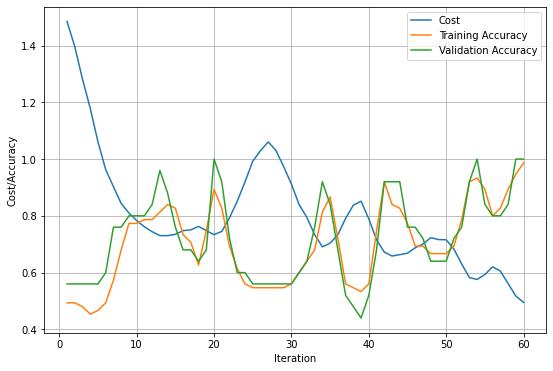

In [35]:
plt.figure(figsize=(9, 6))
plt.plot(metrics['iter'], metrics['cost'], label='Cost')
plt.plot(metrics['iter'], metrics['train_acc'], label='Training Accuracy')
plt.plot(metrics['iter'], metrics['val_acc'], label='Validation Accuracy')
plt.xlabel('Iteration')
plt.ylabel('Cost/Accuracy')
plt.legend()
plt.grid()

##### Plot decision boundary

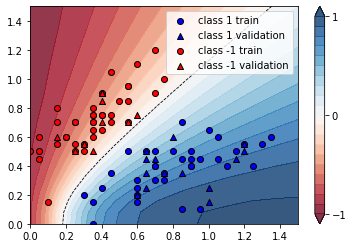

In [36]:
plt.figure()
cm = plt.cm.RdBu

# make data for decision regions
xx, yy = np.meshgrid(np.linspace(0.0, 1.5, 20), np.linspace(0.0, 1.5, 20))
X_grid = [np.array([x, y]) for x, y in zip(xx.flatten(), yy.flatten())]

# preprocess grid points like data inputs above
padding = 0.3 * np.ones((len(X_grid), 1))
X_grid = np.c_[np.c_[X_grid, padding], np.zeros((len(X_grid), 1))]  # pad each input
normalization = np.sqrt(np.sum(X_grid ** 2, -1))
X_grid = (X_grid.T / normalization).T  # normalize each input
features_grid = np.array( [generate_angles(x) for x in X_grid])  # angles for state preparation are new features
predictions_grid = [variational_classifier(var, f, direction) for f in features_grid]
Z = np.reshape(predictions_grid, xx.shape)

# plot decision regions
cnt = plt.contourf(xx, yy, Z, levels=np.arange(-1, 1.1, 0.1), cmap=cm, alpha=0.8, extend="both")
plt.contour(xx, yy, Z, levels=[0.0], colors=("black",), linestyles=("--",), linewidths=(0.8,))
plt.colorbar(cnt, ticks=[-1, 0, 1])

# plot data
plt.scatter(
    X_train[:, 0][Y_train == 1],
    X_train[:, 1][Y_train == 1],
    c="b",
    marker="o",
    edgecolors="k",
    label="class 1 train",
)
plt.scatter(
    X_val[:, 0][Y_val == 1],
    X_val[:, 1][Y_val == 1],
    c="b",
    marker="^",
    edgecolors="k",
    label="class 1 validation",
)
plt.scatter(
    X_train[:, 0][Y_train == -1],
    X_train[:, 1][Y_train == -1],
    c="r",
    marker="o",
    edgecolors="k",
    label="class -1 train",
)
plt.scatter(
    X_val[:, 0][Y_val == -1],
    X_val[:, 1][Y_val == -1],
    c="r",
    marker="^",
    edgecolors="k",
    label="class -1 validation",
)

plt.legend()
plt.show()

### `RX` Gate Encoding

In [37]:
num_qubits = 2
num_layers = 6
var_init = (0.01 * np.random.randn(num_layers, num_qubits, 3), 0.0)
direction = 'X'
opt = NesterovMomentumOptimizer(0.01)
batch_size = 5
iters = 60

In [38]:
metrics = {
    'iter': [],
    'cost': [],
    'train_acc': [],
    'val_acc': []
}

train(num_qubits, num_layers, var_init, direction, opt, batch_size, metrics, iters)

Iter:     1 | Cost: 1.4731792 | Acc train: 0.4933333 | Acc validation: 0.5600000
Iter:     2 | Cost: 1.4150889 | Acc train: 0.4933333 | Acc validation: 0.5600000
Iter:     3 | Cost: 1.3442340 | Acc train: 0.4933333 | Acc validation: 0.5600000
Iter:     4 | Cost: 1.2893683 | Acc train: 0.4800000 | Acc validation: 0.5600000
Iter:     5 | Cost: 1.2298293 | Acc train: 0.4666667 | Acc validation: 0.5600000
Iter:     6 | Cost: 1.1763137 | Acc train: 0.4533333 | Acc validation: 0.5600000
Iter:     7 | Cost: 1.1286155 | Acc train: 0.4533333 | Acc validation: 0.5600000
Iter:     8 | Cost: 1.0866937 | Acc train: 0.4666667 | Acc validation: 0.5600000
Iter:     9 | Cost: 1.0516078 | Acc train: 0.4533333 | Acc validation: 0.5600000
Iter:    10 | Cost: 1.0259594 | Acc train: 0.4800000 | Acc validation: 0.5600000
Iter:    11 | Cost: 1.0088624 | Acc train: 0.4933333 | Acc validation: 0.6000000
Iter:    12 | Cost: 0.9943285 | Acc train: 0.5200000 | Acc validation: 0.6800000
Iter:    13 | Cost: 0.986545

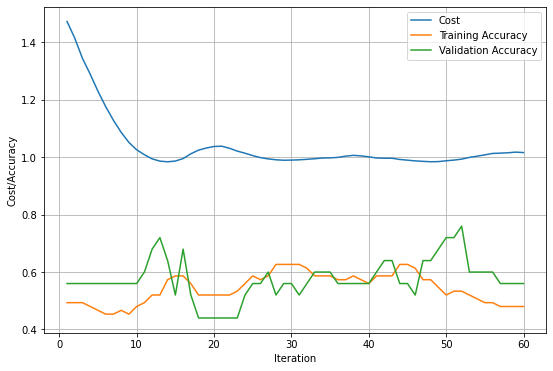

In [39]:
plt.figure(figsize=(9, 6))
plt.plot(metrics['iter'], metrics['cost'], label='Cost')
plt.plot(metrics['iter'], metrics['train_acc'], label='Training Accuracy')
plt.plot(metrics['iter'], metrics['val_acc'], label='Validation Accuracy')
plt.xlabel('Iteration')
plt.ylabel('Cost/Accuracy')
plt.legend()
plt.grid()

##### Plot decision boundary

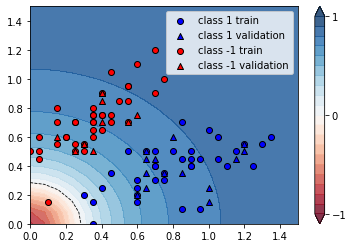

In [40]:
plt.figure()
cm = plt.cm.RdBu

# make data for decision regions
xx, yy = np.meshgrid(np.linspace(0.0, 1.5, 20), np.linspace(0.0, 1.5, 20))
X_grid = [np.array([x, y]) for x, y in zip(xx.flatten(), yy.flatten())]

# preprocess grid points like data inputs above
padding = 0.3 * np.ones((len(X_grid), 1))
X_grid = np.c_[np.c_[X_grid, padding], np.zeros((len(X_grid), 1))]  # pad each input
normalization = np.sqrt(np.sum(X_grid ** 2, -1))
X_grid = (X_grid.T / normalization).T  # normalize each input
features_grid = np.array( [generate_angles(x) for x in X_grid])  # angles for state preparation are new features
predictions_grid = [variational_classifier(var, f, direction) for f in features_grid]
Z = np.reshape(predictions_grid, xx.shape)

# plot decision regions
cnt = plt.contourf(xx, yy, Z, levels=np.arange(-1, 1.1, 0.1), cmap=cm, alpha=0.8, extend="both")
plt.contour(xx, yy, Z, levels=[0.0], colors=("black",), linestyles=("--",), linewidths=(0.8,))
plt.colorbar(cnt, ticks=[-1, 0, 1])

# plot data
plt.scatter(
    X_train[:, 0][Y_train == 1],
    X_train[:, 1][Y_train == 1],
    c="b",
    marker="o",
    edgecolors="k",
    label="class 1 train",
)
plt.scatter(
    X_val[:, 0][Y_val == 1],
    X_val[:, 1][Y_val == 1],
    c="b",
    marker="^",
    edgecolors="k",
    label="class 1 validation",
)
plt.scatter(
    X_train[:, 0][Y_train == -1],
    X_train[:, 1][Y_train == -1],
    c="r",
    marker="o",
    edgecolors="k",
    label="class -1 train",
)
plt.scatter(
    X_val[:, 0][Y_val == -1],
    X_val[:, 1][Y_val == -1],
    c="r",
    marker="^",
    edgecolors="k",
    label="class -1 validation",
)

plt.legend()
plt.show()

### `RZ` Gate Encoding

In [41]:
num_qubits = 2
num_layers = 6
var_init = (0.01 * np.random.randn(num_layers, num_qubits, 3), 0.0)
direction = 'Z'
opt = NesterovMomentumOptimizer(0.01)
batch_size = 5
iters = 60

In [42]:
metrics = {
    'iter': [],
    'cost': [],
    'train_acc': [],
    'val_acc': []
}

train(num_qubits, num_layers, var_init, direction, opt, batch_size, metrics, iters)

Iter:     1 | Cost: 1.9678463 | Acc train: 0.4800000 | Acc validation: 0.5600000
Iter:     2 | Cost: 1.9254062 | Acc train: 0.4800000 | Acc validation: 0.5600000
Iter:     3 | Cost: 1.8602158 | Acc train: 0.4800000 | Acc validation: 0.5600000
Iter:     4 | Cost: 1.7646616 | Acc train: 0.4800000 | Acc validation: 0.5600000
Iter:     5 | Cost: 1.6498280 | Acc train: 0.4800000 | Acc validation: 0.5600000
Iter:     6 | Cost: 1.5265374 | Acc train: 0.4800000 | Acc validation: 0.5600000
Iter:     7 | Cost: 1.3942980 | Acc train: 0.4800000 | Acc validation: 0.5600000
Iter:     8 | Cost: 1.2841599 | Acc train: 0.4800000 | Acc validation: 0.5600000
Iter:     9 | Cost: 1.1817993 | Acc train: 0.4800000 | Acc validation: 0.5600000
Iter:    10 | Cost: 1.1020225 | Acc train: 0.4800000 | Acc validation: 0.5600000
Iter:    11 | Cost: 1.0424570 | Acc train: 0.4800000 | Acc validation: 0.5600000
Iter:    12 | Cost: 1.0111892 | Acc train: 0.4800000 | Acc validation: 0.5600000
Iter:    13 | Cost: 1.000369

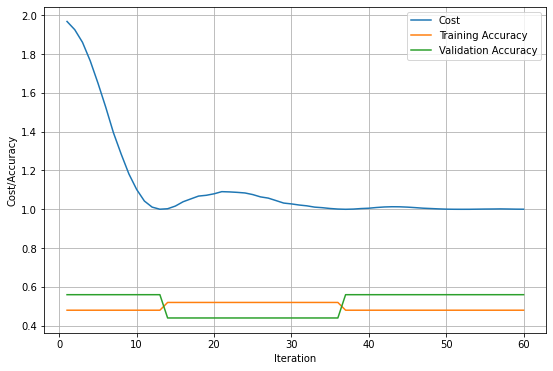

In [43]:
plt.figure(figsize=(9, 6))
plt.plot(metrics['iter'], metrics['cost'], label='Cost')
plt.plot(metrics['iter'], metrics['train_acc'], label='Training Accuracy')
plt.plot(metrics['iter'], metrics['val_acc'], label='Validation Accuracy')
plt.xlabel('Iteration')
plt.ylabel('Cost/Accuracy')
plt.legend()
plt.grid()

##### Plot decision boundary

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: UserWarning: No contour levels were found within the data range.


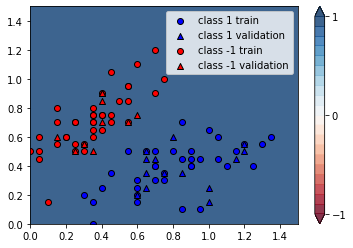

In [44]:
plt.figure()
cm = plt.cm.RdBu

# make data for decision regions
xx, yy = np.meshgrid(np.linspace(0.0, 1.5, 20), np.linspace(0.0, 1.5, 20))
X_grid = [np.array([x, y]) for x, y in zip(xx.flatten(), yy.flatten())]

# preprocess grid points like data inputs above
padding = 0.3 * np.ones((len(X_grid), 1))
X_grid = np.c_[np.c_[X_grid, padding], np.zeros((len(X_grid), 1))]  # pad each input
normalization = np.sqrt(np.sum(X_grid ** 2, -1))
X_grid = (X_grid.T / normalization).T  # normalize each input
features_grid = np.array( [generate_angles(x) for x in X_grid])  # angles for state preparation are new features
predictions_grid = [variational_classifier(var, f, direction) for f in features_grid]
Z = np.reshape(predictions_grid, xx.shape)

# plot decision regions
cnt = plt.contourf(xx, yy, Z, levels=np.arange(-1, 1.1, 0.1), cmap=cm, alpha=0.8, extend="both")
plt.contour(xx, yy, Z, levels=[0.0], colors=("black",), linestyles=("--",), linewidths=(0.8,))
plt.colorbar(cnt, ticks=[-1, 0, 1])

# plot data
plt.scatter(
    X_train[:, 0][Y_train == 1],
    X_train[:, 1][Y_train == 1],
    c="b",
    marker="o",
    edgecolors="k",
    label="class 1 train",
)
plt.scatter(
    X_val[:, 0][Y_val == 1],
    X_val[:, 1][Y_val == 1],
    c="b",
    marker="^",
    edgecolors="k",
    label="class 1 validation",
)
plt.scatter(
    X_train[:, 0][Y_train == -1],
    X_train[:, 1][Y_train == -1],
    c="r",
    marker="o",
    edgecolors="k",
    label="class -1 train",
)
plt.scatter(
    X_val[:, 0][Y_val == -1],
    X_val[:, 1][Y_val == -1],
    c="r",
    marker="^",
    edgecolors="k",
    label="class -1 validation",
)

plt.legend()
plt.show()

From the three experiments conducted, it appears that only a state encoding featuring `RY` gates can provide good results. `RZ` and `RX` gate encodings preformed very poorly -- with an accuracy of just a little over 50% which is just slightly better than a toss of a coin.